In [56]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr


# Load and clean CSV files
file_map = {
    "Banen.csv": "jobs_df",
    "Bevolkingsontwikkeling.csv": "population_df"
}

def clean_columns(df):
    df.columns = [col.replace('ï»¿', '').replace('"', '').strip() for col in df.columns]
    return df

for file, var_name in file_map.items():
    df = pd.read_csv(file, delimiter=';')
    df = clean_columns(df)
    if 'Unnamed: 0' in df.columns:
        df = df.drop(columns=['Unnamed: 0'])
    globals()[var_name] = df

jobs_df = jobs_df.rename(columns={"Jaar": "Year", "Banen": "Jobs"})
population_df = population_df.rename(columns={"Perioden": "Periods", "Bevolking aan het eind van de periode (aantal)": "Population_end_of_period"})

# Check loaded columns
print(jobs_df.columns)
print(population_df.columns)

Index(['Jobs', 'Banen, seizoengecorrigeerd',
       'Banengroei, seizoengecorrigeerd'],
      dtype='object')
Index(['Periods', 'Bevolking aan het begin van de periode (aantal)',
       'Levend geboren kinderen (aantal)', 'Overledenen (aantal)',
       'Immigratie (aantal)',
       'Emigratie inclusief administratieve c... (aantal)',
       'Overige correcties (aantal)', 'Totale bevolkingsgroei (aantal)',
       'Population_end_of_period'],
      dtype='object')


In [57]:
# Voeg een Year-kolom toe aan banen_df
jobs_df["Year"] = range(2014, 2014 + len(jobs_df))
jobs_df["Jobs"] = (
    jobs_df["Jobs"]
    .astype(str)
    .str.replace(" ", "")
    .str.replace(",", ".")
    .pipe(pd.to_numeric, errors="coerce")
)

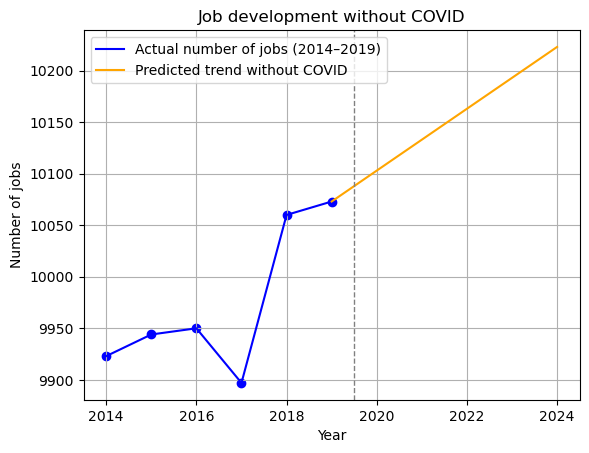

In [59]:
# Stap 1: Selecteer relevante kolommen
jobs_df = jobs_df[["Year", "Jobs"]]

# Stap 3: Bereken gemiddelde Yearlijkse groei
recent_years = jobs_df[(jobs_df["Year"] >= 2014) & (jobs_df["Year"] <= 2019)]
annual_growth = recent_years["Jobs"].diff().mean()

# Stap 4: Voorspel banen voor 2020–2024 op basis van die groei
last_year = recent_years["Year"].max()
last_jobs = recent_years.loc[recent_years["Year"] == last_year, "Jobs"].values[0]

future_years = range(2020, 2025)
future_jobs = [last_jobs + annual_growth * (Year - last_year) for Year in future_years]

predicted_years = [last_year] + list(future_years)
predicted_jobs = [last_jobs] + future_jobs

jobs_extrapolation = pd.DataFrame({
    "Year": predicted_years,
    "Jobs_predicted": predicted_jobs
})

# Stap 6: Visualiseer
# Combineer werkelijke en voorspelde data
jobs_complete = pd.concat([
    recent_years[["Year", "Jobs"]].rename(columns={"Jobs": "Jobs_predicted"}),
    jobs_extrapolation
])

plt.plot(
    recent_years["Year"],
    recent_years["Jobs"],
    label="Actual number of jobs (2014–2019)",
    color="blue"
)
plt.scatter(
    recent_years["Year"],
    recent_years["Jobs"],
    color="blue"
)

# Oranje lijn: voorspelde banen (2020–2024), zonder punten
plt.plot(
    jobs_extrapolation["Year"],
    jobs_extrapolation["Jobs_predicted"],
    label="Predicted trend without COVID",
    color="orange"
)

# Verticale stippellijn bij overgang
plt.axvline(x=2019.5, color="gray", linestyle="--", linewidth=1)

# Labels en layout
plt.xlabel("Year")
plt.ylabel("Number of jobs")
plt.title("Job development without COVID")
plt.legend()
plt.grid(True)
plt.show()

In [60]:
pt_file_map = {
    "PTbefore_TotalDistance.csv": "pt_distance_df",
    "PTbefore_TotalTravelTime.csv": "pt_time_df"
}

for file, name in pt_file_map.items():
    df = pd.read_csv(file, delimiter=',')
    df = clean_columns(df)
    globals()[name] = df
    print(df.columns)

Index(['Year', 'Train_distance_million_km_per_day',
       'BusMetro_distance_million_km_per_day'],
      dtype='object')
Index(['Year', 'Train_travel_time_thousand_hours_per_day',
       'BusMetro_travel_time_thousand_hours_per_day'],
      dtype='object')


In [63]:
# Step 1: Define target columns per file
targets = {
    "pt_distance_df": [
        "Train_distance_million_km_per_day",
        "BusMetro_distance_million_km_per_day"
    ],
    "pt_time_df": [
        "Train_travel_time_thousand_hours_per_day",
        "BusMetro_travel_time_thousand_hours_per_day"
    ]
}

# Step 2: Prepare input for prediction (2020–2024)
jobs_2020_2024 = jobs_complete.set_index("Year").loc[range(2020, 2025), "Jobs_predicted"].values
population_2020_2024 = population_df.set_index("Periods").loc[range(2020, 2025), "Population_end_of_period"].values

X_future = pd.DataFrame({
    "Jobs": jobs_2020_2024,
    "Population": population_2020_2024
})

# Step 3: Train models once and store predictions + stats
predictions = {}
model_stats = {}

for df_name, columns in targets.items():
    df = globals()[df_name]
    for column in columns:
        # Training data: 2014–2019
        train_df = df[(df["Year"] >= 2014) & (df["Year"] <= 2019)].copy()
        train_df["Jobs"] = jobs_df.set_index("Year").loc[train_df["Year"], "Jobs"].values
        train_df["Population"] = population_df.set_index("Periods").loc[train_df["Year"], "Population_end_of_period"].values

        X_train = train_df[["Jobs", "Population"]]
        y_train = train_df[column]

        model = LinearRegression().fit(X_train, y_train)

        # Predict future values
        predicted = model.predict(X_future)
        predictions[column] = predicted

        # Store residual stats
        residuals = y_train - model.predict(X_train)
        std_resid = np.std(residuals)
        r_squared = model.score(X_train, y_train)

        model_stats[column] = {
            "std_resid": std_resid,
            "r_squared": r_squared
        }

# Step 4: Combine predictions into one DataFrame
pt_predicted_df = pd.DataFrame({
    "Year": range(2020, 2025)
})

for column, values in predictions.items():
    pt_predicted_df[column + "_predicted"] = values





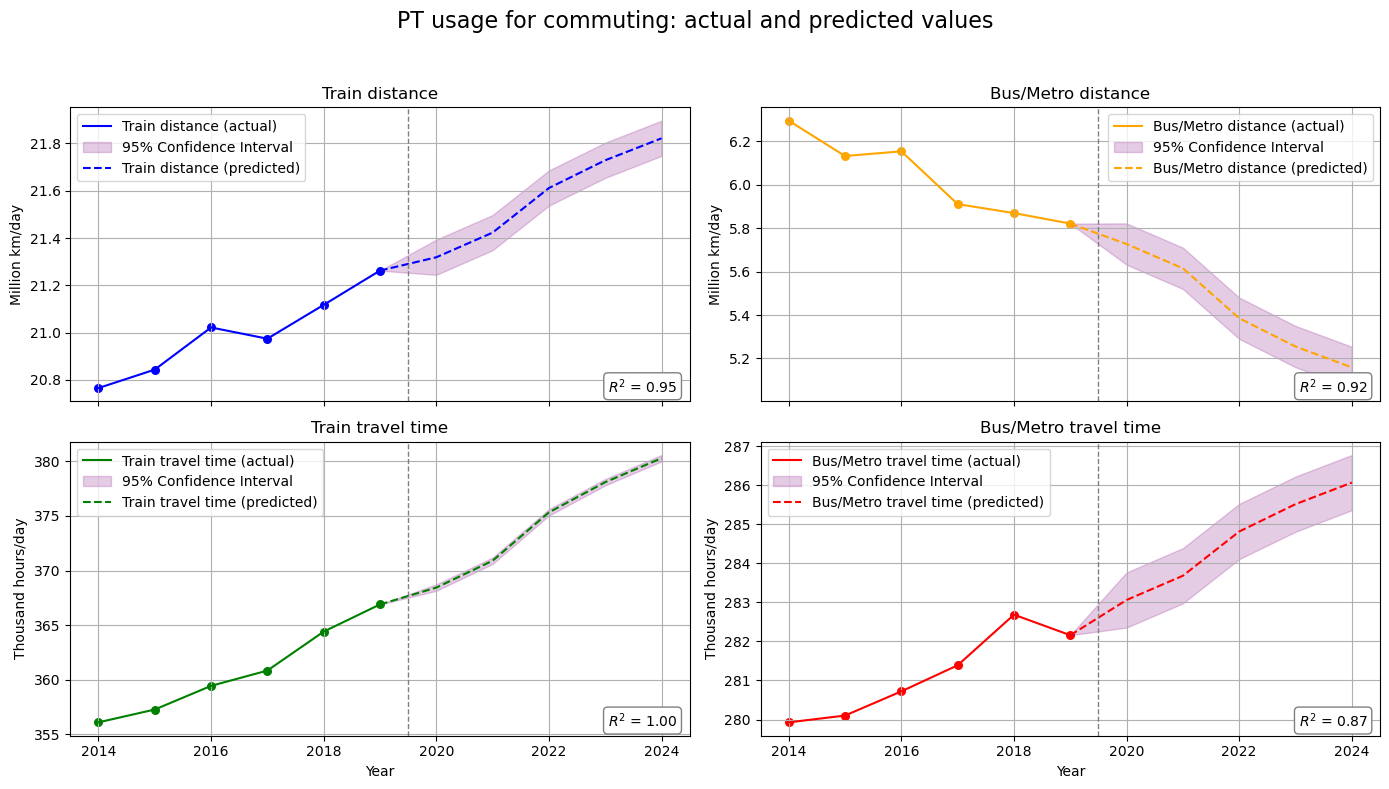

In [64]:
# Visualize actual and predicted PT usage with confidence intervals
fig, axs = plt.subplots(2, 2, figsize=(14, 8), sharex=True)
fig.suptitle("PT usage for commuting: actual and predicted values", fontsize=16)

transport_modes = [
    ("Train_distance_million_km_per_day", "Train distance", "Million km/day", pt_distance_df),
    ("BusMetro_distance_million_km_per_day", "Bus/Metro distance", "Million km/day", pt_distance_df),
    ("Train_travel_time_thousand_hours_per_day", "Train travel time", "Thousand hours/day", pt_time_df),
    ("BusMetro_travel_time_thousand_hours_per_day", "Bus/Metro travel time", "Thousand hours/day", pt_time_df)
]

colors = ["blue", "orange", "green", "red"]

for i, (column, label, y_label, df) in enumerate(transport_modes):
    ax = axs[i // 2, i % 2]

    # Actual data
    ax.plot(df["Year"], df[column], label=f"{label} (actual)", color=colors[i])
    ax.scatter(df["Year"], df[column], color=colors[i], s=30)

    # Predicted data
    predicted = pt_predicted_df[column + "_predicted"]
    predicted_years = pt_predicted_df["Year"]

    # Extend prediction from last actual point
    last_year = df["Year"].max()
    last_value = df.loc[df["Year"] == last_year, column].values[0]
    full_years = [last_year] + list(predicted_years)
    full_values = [last_value] + list(predicted)

    # Confidence interval
    std_resid = model_stats[column]["std_resid"]
    upper = [last_value] + list(predicted + 1.96 * std_resid)
    lower = [last_value] + list(predicted - 1.96 * std_resid)

    ax.fill_between(
        full_years,
        lower,
        upper,
        color="purple",
        alpha=0.2,
        label="95% Confidence Interval"
    )

    # Predicted line
    ax.plot(full_years, full_values, label=f"{label} (predicted)", color=colors[i], linestyle="--")

    # R² annotation
    r_squared = model_stats[column]["r_squared"]
    ax.text(
        0.98, 0.02,
        f"$R^2$ = {r_squared:.2f}",
        transform=ax.transAxes,
        ha="right", va="bottom",
        fontsize=10,
        bbox=dict(facecolor="white", edgecolor="gray", boxstyle="round,pad=0.3")
    )

    # Layout
    ax.axvline(x=2019.5, color="gray", linestyle="--", linewidth=1)
    ax.set_title(label)
    ax.set_ylabel(y_label)
    ax.grid(True)
    ax.legend()

axs[1, 0].set_xlabel("Year")
axs[1, 1].set_xlabel("Year")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

